# Setting up directory

In [ ]:
!mkdir -p ~/.kaggle   # the dot '.' at the beginning of '.kaggle' makes it a hidden directory
!cp fer2013.json ~/.kaggle/   # Trailing '/' ensures that '.kaggle' is treated as a directory

In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 56% 34.0M/60.3M [00:00<00:00, 178MB/s] 
100% 60.3M/60.3M [00:00<00:00, 213MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# Installing Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import imghdr
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data

In [ ]:
project_name = 'FES_2013_Emotion_Detection'

model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir = '/content/'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os.makedirs(model_dir, exist_ok=True)

print(f"project directory structure created at: {project_dir}")

project directory structure created at: /content/FES_2013_Emotion_Detection


# Data Cleaning

In [ ]:
image_exts = ['jpeg', 'jpg', 'png']

data_dir = '/content/train'

for root, dirs, files in os.walk(data_dir):   # 'root' stores the path of the current directory being traversed
  for file in files:
    file_path = os.path.join(root, file)

    try:
      file_type = imghdr.what(file_path)
      if file_type not in image_exts:
        print(f"Image not in ext list: {file_path}")
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)   # returns NumPy array

    except Exception as e:
      print(f"issue with file {file_path}. Error: {e}")
      os.remove(file_path)

# Data Analysis

In [ ]:
def count_files_in_subdirs(directory, set_name):
  counts = {}

  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)

    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  df = pd.DataFrame(counts, index=[set_name])
  return df

In [ ]:
train_dir = '/content/train'
test_dir = '/content/train'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       fear  angry   sad  surprise  disgust  happy  neutral
train  4097   3995  4830      3171      436   7215     4965
      fear  angry   sad  surprise  disgust  happy  neutral
test  4097   3995  4830      3171      436   7215     4965


<Axes: >

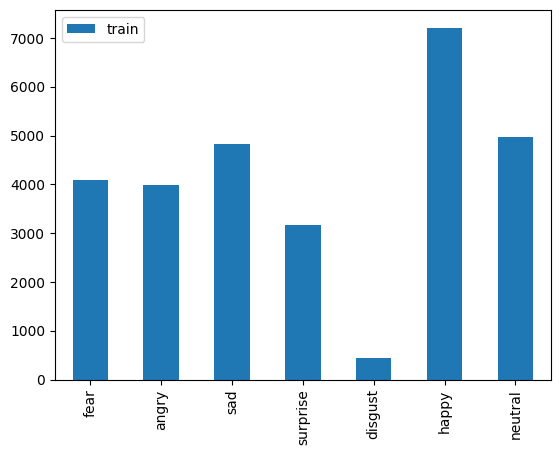

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

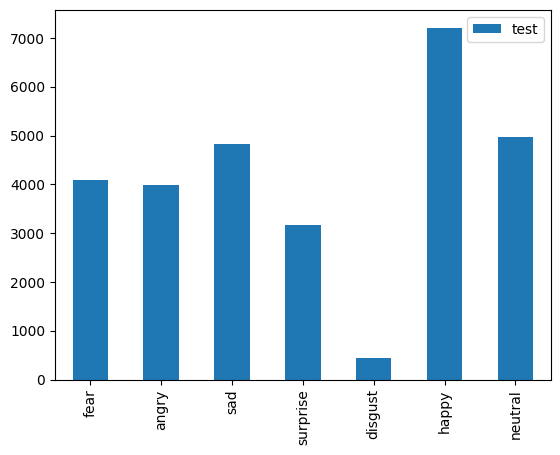

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting 1 image for each emotion

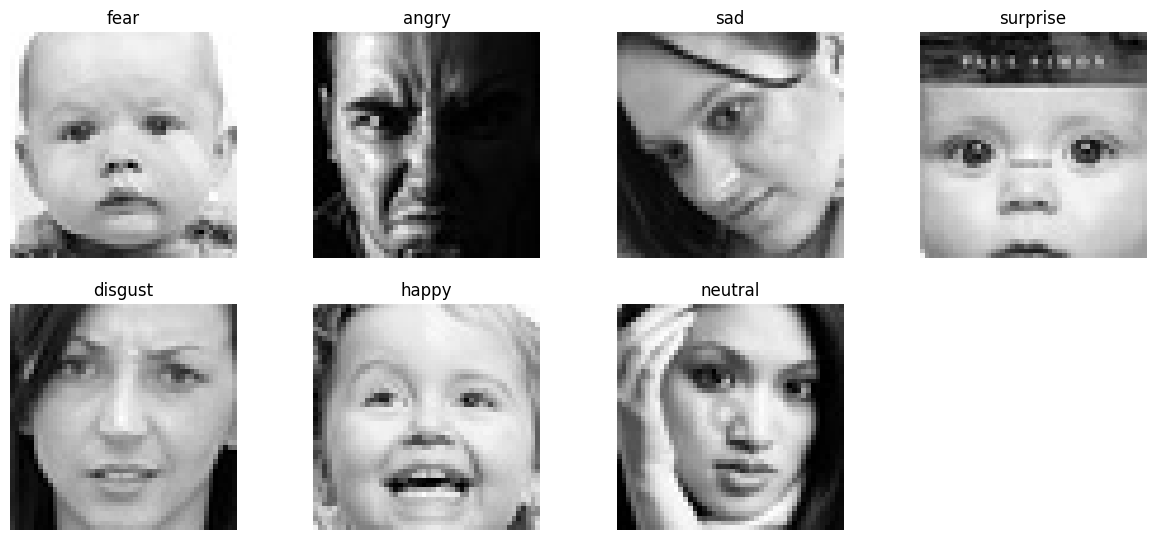

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):   # enumerate generally starts from 0, but here it will start from 1
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[40])
  img = plt.imread(img_path)    # returns numpy array
  plt.subplot(3, 4, i)
  plt.imshow(img, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
  image_filenames = os.listdir(directory_path)

  if len(image_filenames) < num_images:
    print(f"Only found {len(image_filenames)} images, in {directory_path}, displaying them all")
    num_images = len(image_filenames)

  selected_images = random.sample(image_filenames, num_images)

  fig, axes = plt.subplots(3, 3, figsize=(5, 5))
  axes = axes.ravel()   # makes it easier to iterate through the axes

  for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)
    img = load_img(image_path)
    axes[i].imshow(img)
    axes[i].set_title(f'Image: {class_name}')
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

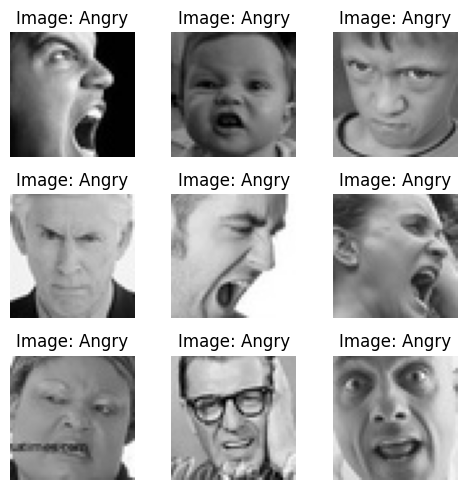

In [ ]:
angry_dir_path = '/content/train/angry'
plot_images_from_directory(angry_dir_path, class_name = 'Angry')

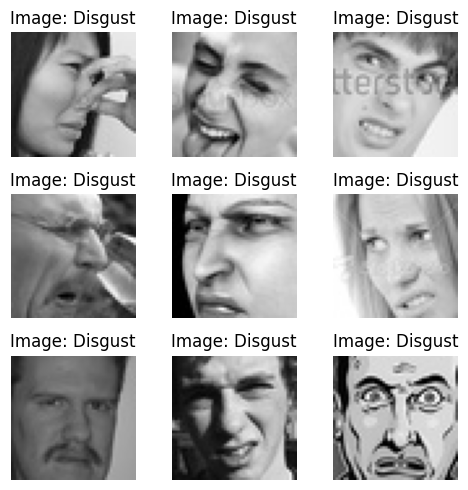

In [ ]:
disgust_dir_path = '/content/train/disgust'
plot_images_from_directory(disgust_dir_path, class_name = 'Disgust')

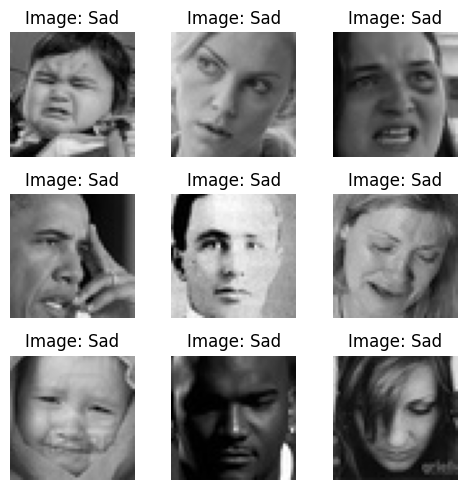

In [ ]:
sad_dir_path = '/content/train/sad'
plot_images_from_directory(sad_dir_path, class_name = 'Sad')

In [ ]:
image = '/content/train/neutral/Training_10055498.jpg'

import cv2

img = cv2.imread(image)   # By default, it reads image in BGR mode

if img is not None:
  print('Shape: ', img.shape)
else:
  print('The couldnot be loaded. Please check the path or file permission')

Shape:  (48, 48, 3)


In [ ]:
image = '/content/train/neutral/Training_10055498.jpg'

import cv2

img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

if img is not None:
  print('Shape: ', img.shape)
else:
  print('The couldnot be loaded. Please check the path or file permission')

Shape:  (48, 48)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [ ]:
len(os.listdir(train_data_dir))

7

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print('Train class labels: ', train_class_labels)

validation_class_labels = validation_generator.class_indices
print('Validation class labels: ', validation_class_labels)

test_class_labels = test_generator.class_indices
print('Test class labels: ', test_class_labels)

Train class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Convolution Layers
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding Dense Layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

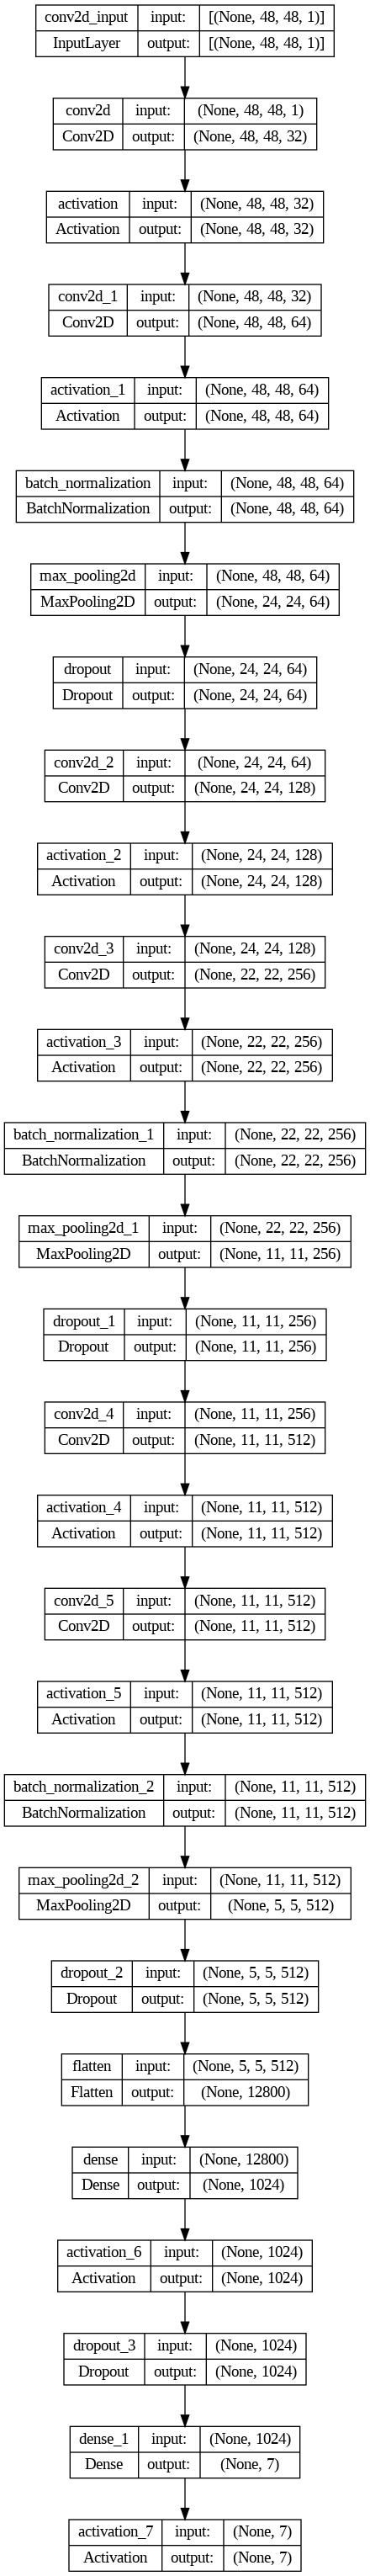

In [ ]:
plot_model(model, to_file = '/content/FES_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True)

## Understanding Callbacks

In [ ]:
cnn_path = '/content/FES_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FES_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

## Calculating Steps per epoch



In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_per_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1
# keras calculates this by default

print(train_steps_per_epoch, validation_steps_per_epoch, test_steps_per_epoch)

359 90 113


## Model Training

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 3.0233 - accuracy: 0.2910
Epoch 1: val_loss improved from inf to 6.37463, saving model to /content/FES_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 39s 80ms/step - loss: 3.0233 - accuracy: 0.2910 - val_loss: 6.3746 - val_accuracy: 0.1738 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 2.6759 - accuracy: 0.3756
Epoch 2: val_loss improved from 6.37463 to 2.77330, saving model to /content/FES_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 [==============================] - 25s 71ms/step - loss: 2.6759 - accuracy: 0.3756 - val_loss: 2.7733 - val_accuracy: 0.3978 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 2.5353 - accuracy: 0.4189
Epoch 3: val_loss did not improve from 2.77330
359/359 [==============================] - 24s 67ms/step - loss: 2.

## Plotting performance Matrics

In [ ]:
def plot_training_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(20, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower left')
  plt.title('Training Accuracy vs Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training Loss vs Validation Loss')

  plt.show()

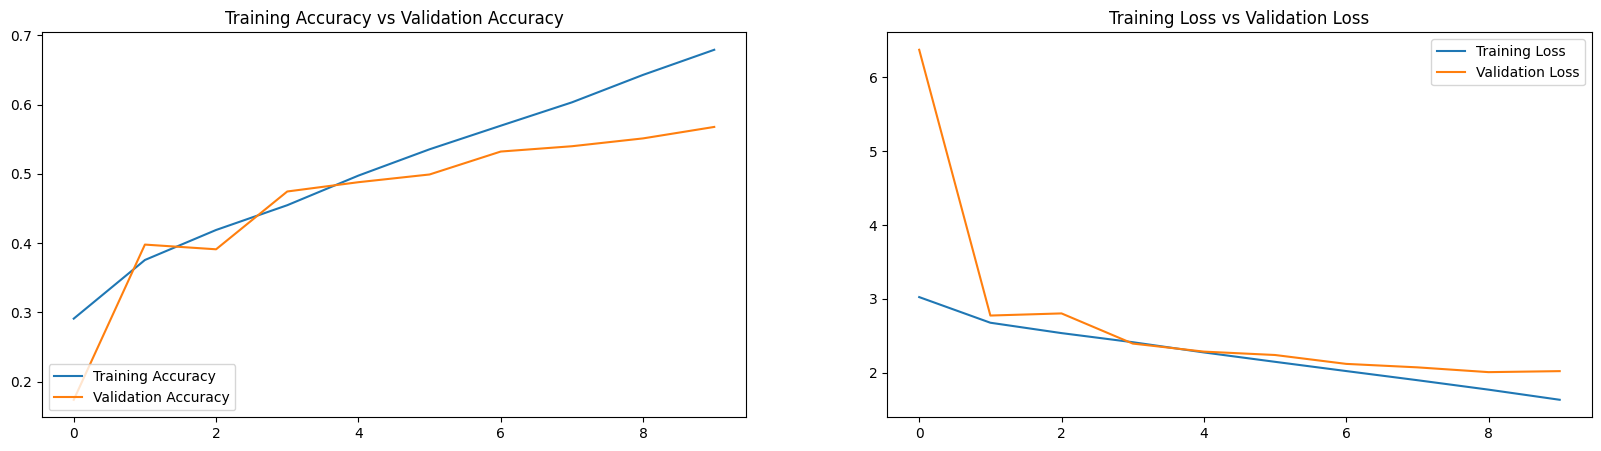

In [ ]:
plot_training_history(history)

## Model Evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(test_generator)

print(f"Final training accuracy: {train_accuracy*100:.2f}, validation_accuracy: {validation_accuracy*100:.2f}")

113/113 [==============================] - 3s 27ms/step - loss: 1.9744 - accuracy: 0.5782
Final training accuracy: 77.93, validation_accuracy: 57.82


## Plotting Confusion Matrix

113/113 [==============================] - 4s 36ms/step


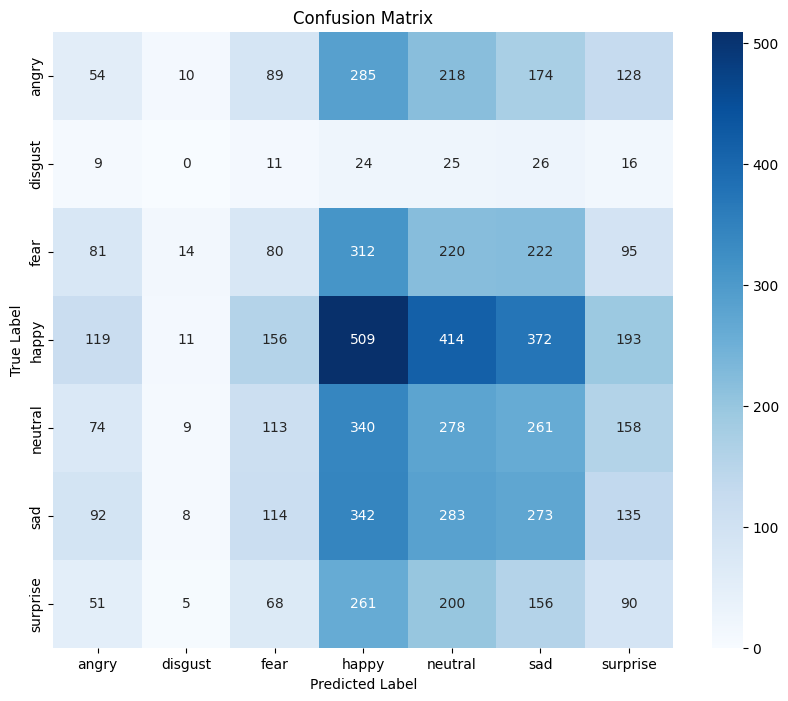

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generating confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(f"Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

       angry       0.11      0.06      0.08       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.08      0.10      1024
       happy       0.25      0.29      0.26      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.18      0.22      0.20      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.18      0.17      7178



# Model 2 : Image Augmentation

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# Parameters
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

# Initializing ImageDataGenerator with Data Augmentation
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test_data_generator = ImageDataGenerator(rescale=1./255)

# Creating the generators
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


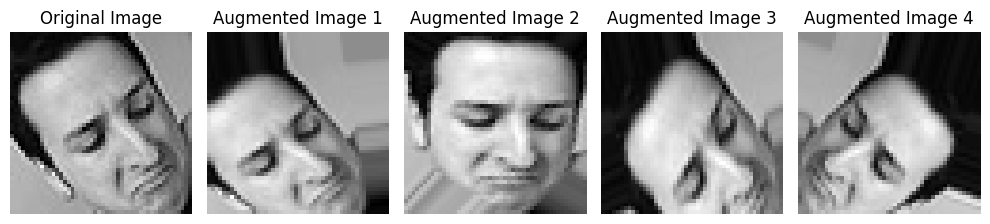

In [ ]:
img_path = '/content/train/disgust/Training_10371709.jpg'

# Load and convert img to array
img = load_img(img_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)   # Reshapes the img to (1, width, height, channels)

fig, axes = plt.subplots(1, 5, figsize=(10, 4))
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, ax in enumerate(axes.flat[1:]):
  aug_iter = data_generator.flow(img_array, batch_size=1)
  aug_img = next(aug_iter)[0]   # get first augmented img from the batch

  ax.imshow(aug_img[:, :, 0], cmap='gray')    # we use [:, :, 0] without an initial batch index
  ax.set_title(f'Augmented Image {i+1}')
  ax.axis('off')

plt.tight_layout()
plt.show()

## Same CNN Model as above

In [ ]:
# Initialising the CNN
model = Sequential()

# Convolution Layers
model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding Dense Layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Understanding Callbacks
cnn_path = '/content/FES_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_model_with_Augmentation.keras'
chk_path = os.path.join(cnn_path, name)
chk_path


# Callback to save model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001)

# Callback to log training data to a CSV
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]


# Model Training
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 3.1442 - accuracy: 0.2268
Epoch 1: val_loss improved from inf to 3.95842, saving model to /content/FES_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_model_with_Augmentation.keras
359/359 [==============================] - 46s 97ms/step - loss: 3.1442 - accuracy: 0.2268 - val_loss: 3.9584 - val_accuracy: 0.1683 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 2.8696 - accuracy: 0.2489
Epoch 2: val_loss improved from 3.95842 to 3.00389, saving model to /content/FES_2013_Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_model_with_Augmentation.keras
359/359 [==============================] - 31s 86ms/step - loss: 2.8696 - accuracy: 0.2489 - val_loss: 3.0039 - val_accuracy: 0.2386 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 2.8171 - accuracy: 0.2595
Epoch 3: val_loss improved from 3.00389 to 2.83649, saving model to 

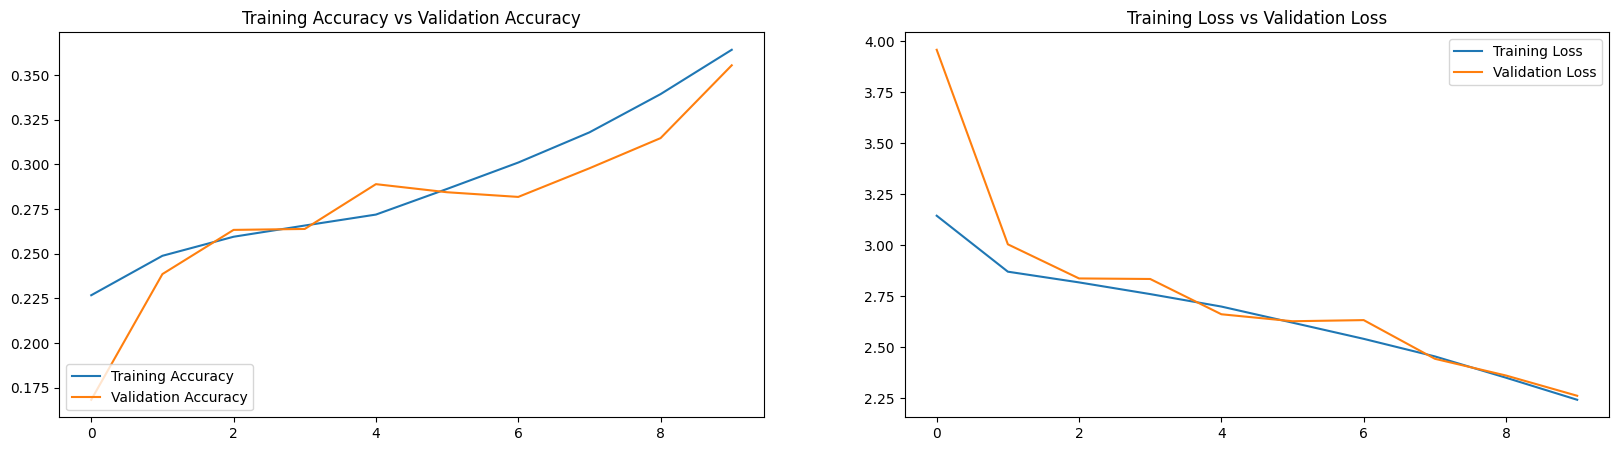

In [ ]:
plot_training_history(history)

## Model Evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(test_generator)

print(f"Final training accuracy: {train_accuracy*100:.2f}, validation_accuracy: {validation_accuracy*100:.2f}")

113/113 [==============================] - 3s 27ms/step - loss: 2.1291 - accuracy: 0.4195
Final training accuracy: 35.95, validation_accuracy: 41.95


## Plotting Confusion Matrix

113/113 [==============================] - 4s 38ms/step


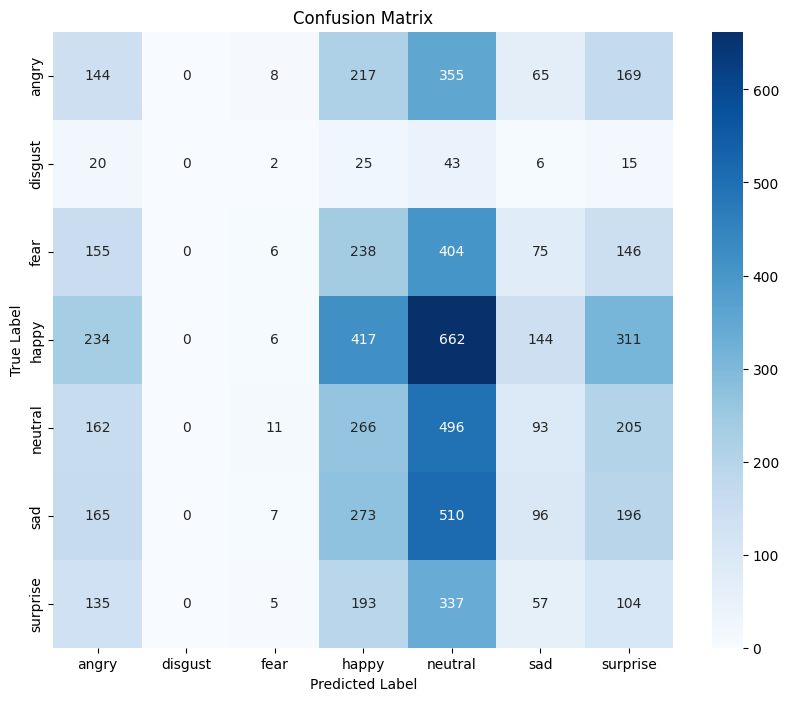

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generating confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model 3 : Transfer Learning VGGNet

In [ ]:
test_data_dir = '/content/test'
train_data_dir = '/content/train'

# setting parameters
img_width, img_height = 224, 224    # input of VGGNET is (224, 224, 3)
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(
    rescale=1/255.
)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',     # replicating the image 3 times so that model treats it as rgb (input is (224, 224, 3))
    shuffle=True
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Handling Imbalances using Class Weights

In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights are : ', class_weights_dict)

Class weights are :  {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
classes = 7

# clear previous tensorflow sessions
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top(fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in vgg.layers[:-3]:
  layer.trainable=False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
x = Flatten()(vgg.output)

x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# creating model
model = Model(inputs=vgg.input, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
cnn_path = '/content/FES_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)
chk_path


checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.5778 - accuracy: 0.4034
Epoch 1: val_loss improved from inf to 1.40504, saving model to /content/FES_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 450s 1s/step - loss: 1.5778 - accuracy: 0.4034 - val_loss: 1.4050 - val_accuracy: 0.4621 - lr: 1.0000e-04
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 1.4784 - accuracy: 0.4323
Epoch 2: val_loss improved from 1.40504 to 1.31735, saving model to /content/FES_2013_Emotion_Detection/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 484s 1s/step - loss: 1.4784 - accuracy: 0.4323 - val_loss: 1.3174 - val_accuracy: 0.5026 - lr: 1.0000e-04
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 1.4010 - accuracy: 0.4574
Epoch 3: val_loss improved from 1.31735 to 1.26109, saving model to /content/FES_2013_Emotion_Detectio

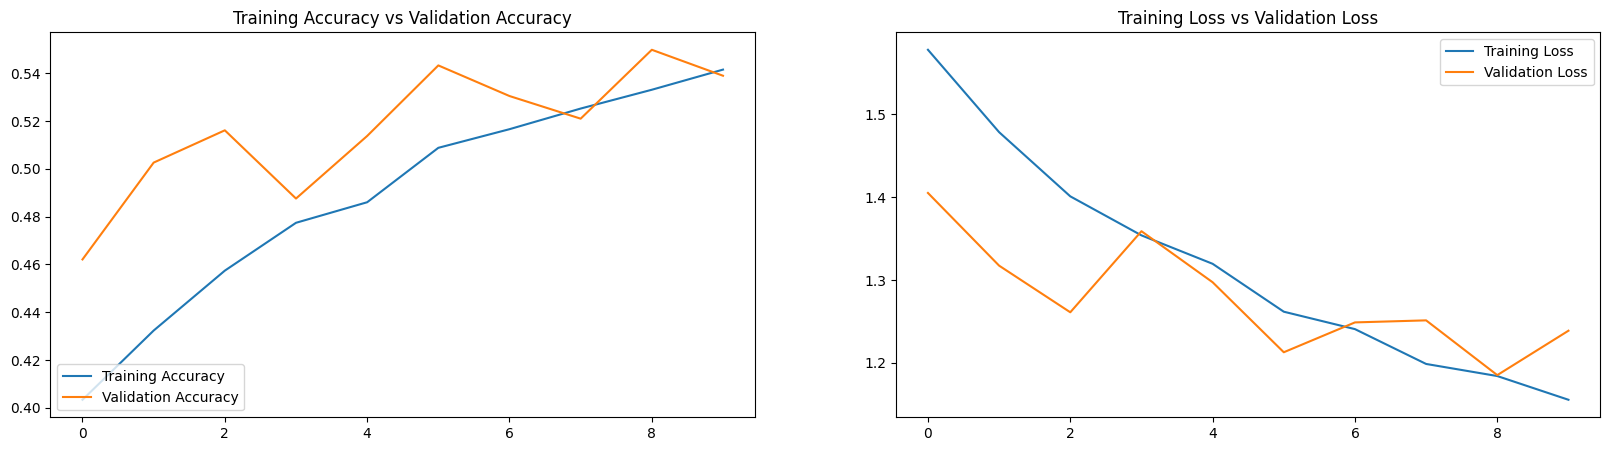

In [ ]:
plot_training_history(history)

## Model Evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(test_generator)

print(f"Final training accuracy: {train_accuracy*100:.2f}, validation_accuracy: {validation_accuracy*100:.2f}")

113/113 [==============================] - 32s 285ms/step - loss: 1.2389 - accuracy: 0.5390
Final training accuracy: 53.73, validation_accuracy: 53.90


## Plotting Confusion Matrix

113/113 [==============================] - 31s 275ms/step


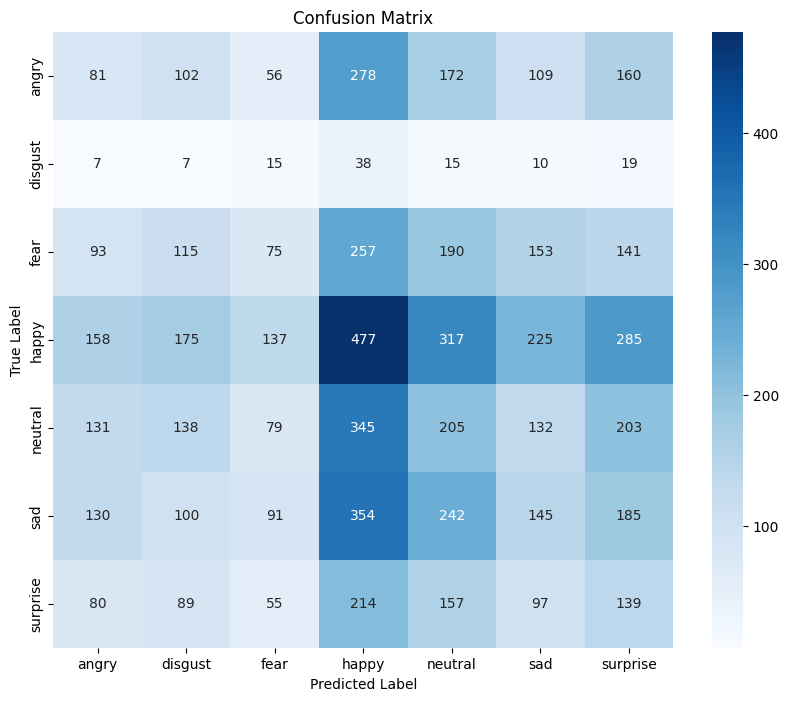

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generating confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Classification Report

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(f"Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

       angry       0.12      0.08      0.10       958
     disgust       0.01      0.06      0.02       111
        fear       0.15      0.07      0.10      1024
       happy       0.24      0.27      0.26      1774
     neutral       0.16      0.17      0.16      1233
         sad       0.17      0.12      0.14      1247
    surprise       0.12      0.17      0.14       831

    accuracy                           0.16      7178
   macro avg       0.14      0.13      0.13      7178
weighted avg       0.17      0.16      0.16      7178



# Model 4 : Transfer Learning ResNet50

In [ ]:
test_data_dir = '/content/test'
train_data_dir = '/content/train'

img_width, img_height = 224, 224
batch_size = 64

data_generator = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_preprocessor = ImageDataGenerator(
    rescale=1/255.
)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',     # replicating the image 3 times so that model treats it as rgb (input is (224, 224, 3))
    shuffle=True
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Handling Imabalances using Class Weights

In [ ]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
print('Class weights are : ', class_weights_dict)

Class weights are :  {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
  layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():
  model = Sequential([
      ResNet50V2,
      Dropout(0.25),
      BatchNormalization(),
      Flatten(),
      Dense(64, activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(7, activation='softmax')
  ])

  return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnn_path = '/content/FES_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)
chk_path


checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss')

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
train_history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    class_weight=class_weights_dict,
                    callbacks=callbacks)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 1.8312 - accuracy: 0.3556
Epoch 1: val_loss improved from inf to 1.99613, saving model to /content/FES_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 437s 934ms/step - loss: 1.8312 - accuracy: 0.3556 - val_loss: 1.9961 - val_accuracy: 0.4865 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 1.4825 - accuracy: 0.4531
Epoch 2: val_loss improved from 1.99613 to 1.67256, saving model to /content/FES_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras
449/449 [==============================] - 422s 939ms/step - loss: 1.4825 - accuracy: 0.4531 - val_loss: 1.6726 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 1.3977 - accuracy: 0.4878
Epoch 3: val_loss improved from 1.67256 to 1.22843, saving model to /content/FES_2013_Emotio

### Saving Model

In [ ]:
model.save('Test_model.keras')

In [ ]:
plot_training_history(train_history)

## Model Evaluation

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
validation_loss, validation_accuracy = model.evaluate(test_generator)

print(f"Final training accuracy: {train_accuracy*100:.2f}, validation_accuracy: {validation_accuracy*100:.2f}")

113/113 [==============================] - 19s 171ms/step - loss: 0.9042 - accuracy: 0.6773
Final training accuracy: 74.56, validation_accuracy: 67.73


## Confusion Matrix

113/113 [==============================] - 20s 176ms/step


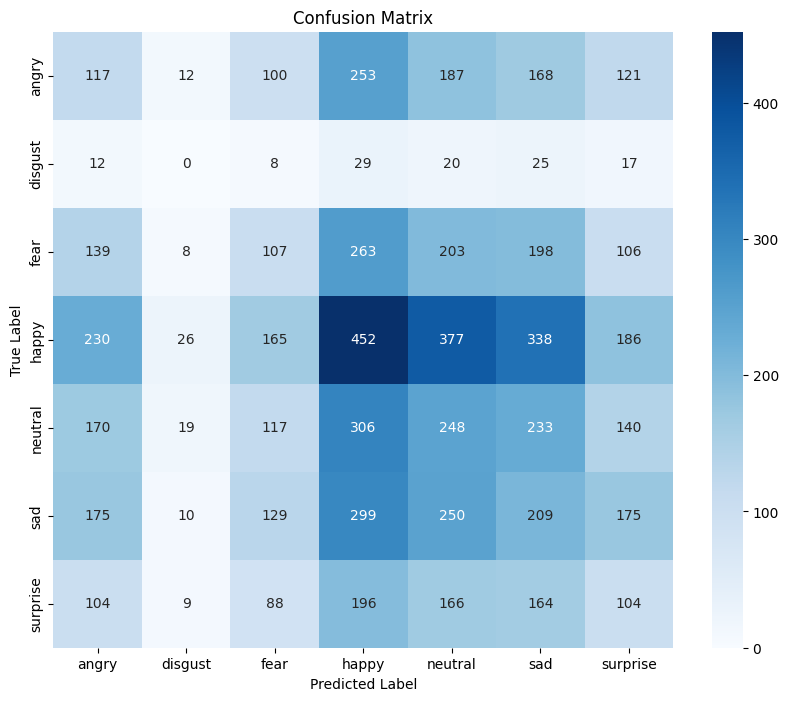

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generating confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Classification Report

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(f"Classification Report: \n", report)

Classification Report: 
               precision    recall  f1-score   support

       angry       0.12      0.12      0.12       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.20      0.18      1233
         sad       0.16      0.17      0.16      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



### Loading Model

In [ ]:
import keras

satyam = keras.saving.load_model('/content/Final_Resnet50_Best_model.keras')

In [ ]:
test_loss, test_accu = satyam.evaluate(test_generator)
print(test_loss, test_accu)

# AUC ROC plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes = list(test_generator.class_indices.keys())

113/113 [==============================] - 22s 197ms/step


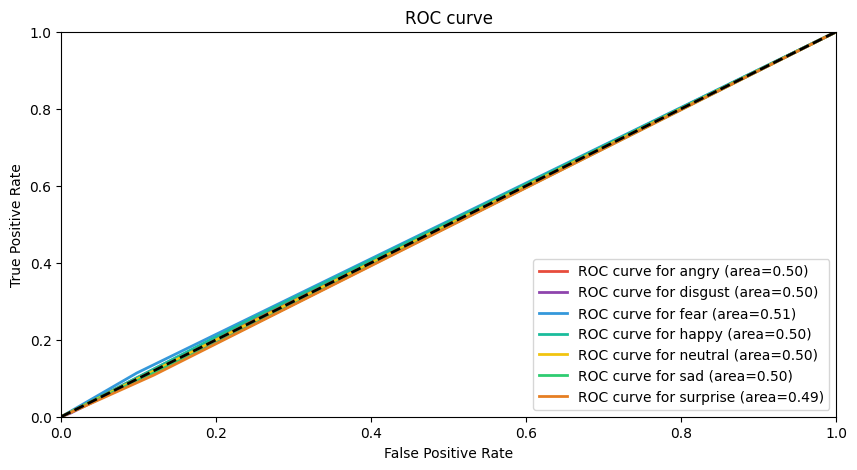

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(7):
  fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])   # '_' stores the thershold values
  roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 5))
colors = ['#e74c3c', '#8e44ad', '#3498db', '#1abc9c', '#f1c40f', '#2ecc71', '#e67e22']
for i, color in enumerate(colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area={roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)   # k-- represents a black dashed line; from (0,0) to (1,1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')

# Gradio : For deployment

## Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip3 install gradio

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gradio as gr
import tensorflow as tf
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [ ]:
!nvidia-smi   # to see the version of gpu assigned by colab

Wed Jun 12 10:33:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              30W /  70W |  11387MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Loading the model

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Final_Resnet50_Best_model.keras')

In [ ]:
emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
index_to_emotion = {v: k for k, v in emotion_labels.items()}
index_to_emotion

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

## Define the gradio interface

In [ ]:
def prepare_image(img_pil):
  """Preprocess PIL image to fit the model's requirements"""
  img = img_pil.resize((224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)   # convert single image to a batch
  img_array /= 255.0
  return img_array


def predict_emotion(image):
  processed_image = prepare_image(image)    # preprocess the image
  prediction = model.predict(processed_image)
  predicted_class = np.argmax(prediction, axis=1)
  predicted_emotion = index_to_emotion.get(predicted_class[0], "Unknown Emotion")
  return predicted_emotion


interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="pil"),   # directly compatible with PIL image
    outputs="text",
    title="Emotion Detection",
    description="Upload an image to see the predicted emotion"
)

# Laund the Gradio interface
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0df5b7e01c9e506d48.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
